In [1]:
import os
import numpy as np
import glob
import multiprocessing
import time
import seaborn as sns
from multiprocessing import Pool

import matplotlib.pyplot as plt

from yaml import load
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.regularizers import L1L2

from keras.callbacks import ReduceLROnPlateau

%matplotlib inline

Using TensorFlow backend.


In [2]:
log_path = 'logs/13/'
stats = [
    'dmean',     # 0 - mean of the derivative
    'dmean2',    # 1 - mean of the second derivative
    'dvar',      # 2 - variance of the derivative
    'dvar2',     # 3 - variance of the second derivative
    'kurt',      # 4 - kurtosis
    'max',       # 5 - maximum
    'mean',      # 6
    'median',    # 7
    'min',       # 8 - minimum
    'skew',      # 9 - skewness
    'stdev',     # 10 - standard deviation
    'var',       # 11 - variance    
]

genres = [
    'blues',     # 0
    'classical', # 1
    'country',   # 2
    'disco',     # 3
    'hiphop',    # 4
    'jazz',      # 5
    'metal',     # 6
    'pop',       # 7
    'reggae',    # 8
    'rock',      # 9
]

### Data loading and preparation

In [3]:
def process_path(class_music):
    """ Process path
    Method to get all data from the dataset provided by Essentia.
    """
    print('Processing: {}'.format(class_music))
    start_time = time.time()

    X = [] # store all data provided by Essentia
    y = [] # store all classes

    for subdir, dirs, filenames in os.walk(log_path + class_music + '/'):
        for file in filenames:
            # get actual file path
            fpath = subdir + '/' + file
            # verify file status
            if (os.path.exists(fpath)):
                # put file on a stream
                stream = open(fpath, 'r')
                # use yaml loader to read the data
                data = load(stream, Loader=Loader)

                for stat in stats:
                    # store only data requested
                    X.append(data['lowlevel']['mfcc'][stat])
                y.append(genres.index(class_music))

    print('Processed: {}, time cost = {:06.3f}s'.format(class_music, time.time() - start_time))
    return X, y

In [4]:
if __name__ == '__main__':
    with Pool(multiprocessing.cpu_count()) as p:
        X, y = zip(*p.map(process_path, genres))

Processing: blues
Processing: classical
Processing: disco
Processing: country
Processing: jazz
Processing: metal
Processing: pop
Processing: hiphop
Processing: reggae
Processing: rock
Processed: blues, time cost = 30.093s
Processed: country, time cost = 30.097s
Processed: rock, time cost = 41.554s
Processed: jazz, time cost = 41.569s
Processed: pop, time cost = 41.856s
Processed: hiphop, time cost = 41.892s
Processed: reggae, time cost = 46.053s
Processed: metal, time cost = 46.068s
Processed: classical, time cost = 46.804s
Processed: disco, time cost = 46.883s


(1000, 156) float64


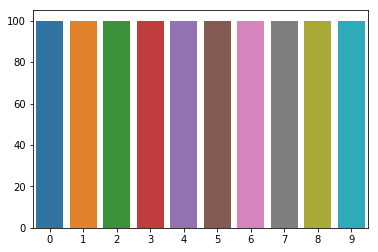

In [5]:
X_reshaped = np.asarray(X).reshape(1000, 156)
print(X_reshaped.shape, X_reshaped.dtype)

y_reshaped = np.asarray(y).reshape(1000)
v, c = np.unique(y_reshaped, return_counts=True)
sns.barplot(v, c)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_reshaped, test_size=0.33, random_state=33, stratify=y_reshaped)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(670, 156) (330, 156) (670,) (330,)


In [7]:
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
print(y_train.shape, y_val.shape)

(670, 10) (330, 10)


In [8]:
def create_model():
    inp = Input(shape=(X_train.shape[1],))
    x = Dense(128, kernel_regularizer=L1L2(l1=0.01, l2=0.01))(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.6)(x)
    
    x = Dense(128, kernel_regularizer=L1L2(l1=0.01, l2=0.01))(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.8)(x)

    x = Dense(10)(x)
    x = Activation('softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [9]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 156)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               20096     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total para

In [10]:
X_train_means = X_train.mean(axis=0)
X_train_stds = X_train.std(axis=0)

print('Means:', X_train_means)
print('Stds:', X_train_stds)

Means: [ 2.26207458e+01  1.25134302e+01  1.03070629e+01  7.95241564e+00
  7.30417710e+00  6.92729047e+00  6.59581708e+00  6.20112557e+00
  6.00669474e+00  5.86610981e+00  5.67041264e+00  5.50522086e+00
  5.38082539e+00  2.77663961e+01  1.69717797e+01  1.43366817e+01
  1.15643215e+01  1.08068215e+01  1.02528811e+01  9.84639894e+00
  9.36560593e+00  9.12497359e+00  8.92501078e+00  8.69727700e+00
  8.46675358e+00  8.29491344e+00  8.04855401e+02  1.94840779e+02
  1.12269196e+02  5.53286412e+01  4.53446779e+01  3.82062969e+01
  3.26436862e+01  2.73562637e+01  2.53044711e+01  2.37696029e+01
  2.19128876e+01  2.01648380e+01  1.93455210e+01  1.41374320e+03
  3.48878914e+02  2.01744499e+02  1.10258612e+02  9.34793760e+01
  7.82210896e+01  6.87822119e+01  5.95338691e+01  5.60218407e+01
  5.26703076e+01  4.95140167e+01  4.64466115e+01  4.45944027e+01
  4.77306258e-01  5.10783158e-01  6.81314682e-02  1.22965809e-01
  1.01614365e-01  1.16765556e-01  1.33065742e-01  2.09163749e-01
  1.62008272e-01  

In [11]:
X_train -= X_train_means
X_train /= X_train_stds

print('Means:', X_train.mean(axis=0))
print('Std:', X_train.std(axis=0))

Means: [-1.79359015e-15  3.56265597e-17  4.44950875e-15  1.92681691e-15
 -5.36552560e-16 -6.21393484e-18  4.70585428e-15 -3.00329827e-15
  4.83526983e-16 -4.90813857e-15  4.16971598e-15  3.47176682e-15
 -1.61765294e-15  4.33484094e-16 -1.95457249e-15  5.28267314e-16
 -6.19206179e-15  4.15786808e-15  1.89908205e-15  8.92076628e-15
  5.42905273e-15  1.83348361e-15  2.80917495e-15  4.75200310e-15
  2.86826947e-15  4.30256991e-15  6.79390209e-18 -4.57097047e-16
  3.20804743e-16 -1.31834842e-15  7.67710936e-16  3.31503067e-16
  1.95863226e-15 -2.45657557e-17 -6.78520258e-16  1.27634222e-16
 -3.26438710e-17  1.78745907e-15  3.59248286e-15  1.51205748e-16
 -8.24216317e-16 -1.40219511e-15  2.53130850e-15  6.72513455e-16
  2.24183234e-16  1.05902020e-15  7.65805330e-16 -1.76790589e-15
  2.00743236e-15  3.91092631e-15 -2.57439178e-15 -1.29233274e-15
  1.03565581e-16 -1.22828779e-16 -1.46566010e-16  2.32318311e-16
  4.12605273e-17  5.03742984e-17 -5.04985771e-17  2.65127886e-17
 -7.78813167e-18  

In [12]:

X_val -= X_train_means
X_val /= X_train_stds

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=20, min_lr=0.00001)

In [14]:
model = create_model()
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=300, 
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr])

Train on 670 samples, validate on 330 samples
Epoch 1/300
670/670 [==============================] - 1s - loss: 18.5074 - acc: 0.1537 - val_loss: 16.4038 - val_acc: 0.2727
Epoch 2/300
670/670 [==============================] - 0s - loss: 16.3572 - acc: 0.2090 - val_loss: 14.5499 - val_acc: 0.4212
Epoch 3/300
670/670 [==============================] - 0s - loss: 14.4727 - acc: 0.2657 - val_loss: 12.9331 - val_acc: 0.4606
Epoch 4/300
670/670 [==============================] - 0s - loss: 12.8362 - acc: 0.3313 - val_loss: 11.4363 - val_acc: 0.5242
Epoch 5/300
670/670 [==============================] - 0s - loss: 11.2222 - acc: 0.3761 - val_loss: 10.0898 - val_acc: 0.5667
Epoch 6/300
670/670 [==============================] - 0s - loss: 9.8426 - acc: 0.4224 - val_loss: 8.8909 - val_acc: 0.6030
Epoch 7/300
670/670 [==============================] - 0s - loss: 8.6880 - acc: 0.4433 - val_loss: 7.7991 - val_acc: 0.6364
Epoch 8/300
670/670 [==============================] - 0s - loss: 7.5700 - a

670/670 [==============================] - 0s - loss: 2.1127 - acc: 0.5597 - val_loss: 1.8598 - val_acc: 0.7424
Epoch 67/300
670/670 [==============================] - 0s - loss: 2.0325 - acc: 0.5925 - val_loss: 1.8303 - val_acc: 0.7697
Epoch 68/300
670/670 [==============================] - 0s - loss: 2.1587 - acc: 0.5522 - val_loss: 1.8029 - val_acc: 0.7182
Epoch 69/300
670/670 [==============================] - 0s - loss: 2.1343 - acc: 0.5418 - val_loss: 1.8188 - val_acc: 0.7515
Epoch 70/300
670/670 [==============================] - 0s - loss: 2.0305 - acc: 0.5881 - val_loss: 1.8047 - val_acc: 0.7182
Epoch 71/300
670/670 [==============================] - 0s - loss: 1.9948 - acc: 0.5881 - val_loss: 1.7852 - val_acc: 0.7394
Epoch 72/300
670/670 [==============================] - 0s - loss: 2.0029 - acc: 0.5970 - val_loss: 1.8236 - val_acc: 0.7394
Epoch 73/300
670/670 [==============================] - 0s - loss: 2.0168 - acc: 0.5761 - val_loss: 1.8116 - val_acc: 0.7455
Epoch 74/300


670/670 [==============================] - 0s - loss: 1.7504 - acc: 0.6552 - val_loss: 1.6277 - val_acc: 0.7697
Epoch 132/300
670/670 [==============================] - 0s - loss: 1.6584 - acc: 0.6910 - val_loss: 1.5940 - val_acc: 0.7636
Epoch 133/300
670/670 [==============================] - 0s - loss: 1.6712 - acc: 0.6567 - val_loss: 1.5564 - val_acc: 0.7697
Epoch 134/300
670/670 [==============================] - 0s - loss: 1.5845 - acc: 0.6791 - val_loss: 1.5312 - val_acc: 0.7727
Epoch 135/300
670/670 [==============================] - 0s - loss: 1.5995 - acc: 0.6806 - val_loss: 1.5116 - val_acc: 0.7697
Epoch 136/300
670/670 [==============================] - 0s - loss: 1.5351 - acc: 0.6791 - val_loss: 1.4919 - val_acc: 0.7727
Epoch 137/300
670/670 [==============================] - 0s - loss: 1.4960 - acc: 0.6896 - val_loss: 1.4623 - val_acc: 0.7727
Epoch 138/300
670/670 [==============================] - 0s - loss: 1.5104 - acc: 0.6716 - val_loss: 1.4408 - val_acc: 0.7758
Epoch 

670/670 [==============================] - 0s - loss: 1.1194 - acc: 0.7478 - val_loss: 1.1239 - val_acc: 0.7788
Epoch 197/300
670/670 [==============================] - 0s - loss: 1.0970 - acc: 0.7582 - val_loss: 1.1212 - val_acc: 0.7727
Epoch 198/300
670/670 [==============================] - 0s - loss: 1.1320 - acc: 0.7478 - val_loss: 1.1171 - val_acc: 0.7727
Epoch 199/300
670/670 [==============================] - 0s - loss: 1.1016 - acc: 0.7507 - val_loss: 1.1190 - val_acc: 0.7636
Epoch 200/300
670/670 [==============================] - 0s - loss: 1.1132 - acc: 0.7373 - val_loss: 1.1090 - val_acc: 0.7758
Epoch 201/300
670/670 [==============================] - 0s - loss: 1.1035 - acc: 0.7284 - val_loss: 1.1213 - val_acc: 0.7818
Epoch 202/300
670/670 [==============================] - 0s - loss: 1.1302 - acc: 0.7493 - val_loss: 1.1139 - val_acc: 0.7667
Epoch 203/300
670/670 [==============================] - 0s - loss: 1.1059 - acc: 0.7373 - val_loss: 1.1124 - val_acc: 0.7576
Epoch 

670/670 [==============================] - 0s - loss: 0.9615 - acc: 0.7925 - val_loss: 1.0308 - val_acc: 0.7848
Epoch 262/300
670/670 [==============================] - 0s - loss: 0.9838 - acc: 0.7776 - val_loss: 1.0288 - val_acc: 0.7848
Epoch 263/300
670/670 [==============================] - 0s - loss: 0.9983 - acc: 0.7776 - val_loss: 1.0267 - val_acc: 0.7848
Epoch 264/300
670/670 [==============================] - 0s - loss: 0.9769 - acc: 0.7910 - val_loss: 1.0280 - val_acc: 0.7818
Epoch 265/300
670/670 [==============================] - 0s - loss: 0.9981 - acc: 0.7866 - val_loss: 1.0283 - val_acc: 0.7848
Epoch 266/300
670/670 [==============================] - 0s - loss: 0.9283 - acc: 0.7955 - val_loss: 1.0281 - val_acc: 0.7879
Epoch 267/300
670/670 [==============================] - 0s - loss: 0.9772 - acc: 0.7866 - val_loss: 1.0277 - val_acc: 0.7848
Epoch 268/300
670/670 [==============================] - 0s - loss: 0.9613 - acc: 0.7970 - val_loss: 1.0251 - val_acc: 0.7848
Epoch 

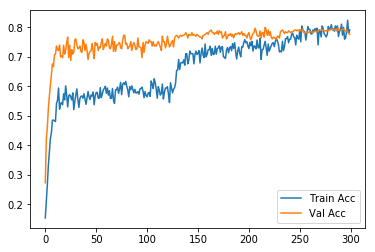

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train Acc', 'Val Acc'])

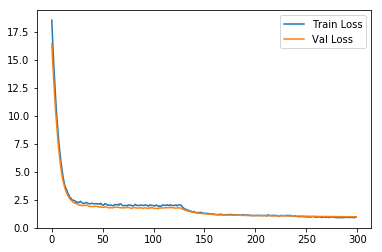

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

In [17]:
y_train_pred = model.predict(X_train)
y_train_pred_max = np.argmax(y_train_pred, axis=1)
y_train_max = np.argmax(y_train, axis=1)

print('Train')
print(classification_report(y_train_max, y_train_pred_max))

Train
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        67
           1       0.94      1.00      0.97        67
           2       0.94      0.94      0.94        67
           3       0.94      0.97      0.96        67
           4       0.97      0.90      0.93        67
           5       0.98      0.96      0.97        67
           6       0.96      1.00      0.98        67
           7       0.97      0.97      0.97        67
           8       0.94      0.94      0.94        67
           9       0.89      0.85      0.87        67

   micro avg       0.95      0.95      0.95       670
   macro avg       0.95      0.95      0.95       670
weighted avg       0.95      0.95      0.95       670



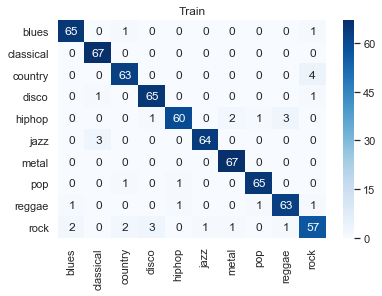

In [18]:
cm = confusion_matrix(y_train_max, y_train_pred_max)
sns.set()
plt.figure()
plt.title('Train')
sns.heatmap(cm, annot=True, yticklabels=genres, xticklabels=genres, cmap='Blues')

In [19]:
y_pred = model.predict(X_val)
y_pred_max = np.argmax(y_pred, axis=1)
y_max = np.argmax(y_val, axis=1)

print('Val')
print(classification_report(y_max, y_pred_max))

Val
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        33
           1       0.97      0.94      0.95        33
           2       0.74      0.70      0.72        33
           3       0.63      0.73      0.68        33
           4       0.72      0.70      0.71        33
           5       0.88      0.91      0.90        33
           6       0.86      0.94      0.90        33
           7       0.73      0.82      0.77        33
           8       0.68      0.64      0.66        33
           9       0.82      0.55      0.65        33

   micro avg       0.78      0.78      0.78       330
   macro avg       0.78      0.78      0.77       330
weighted avg       0.78      0.78      0.77       330



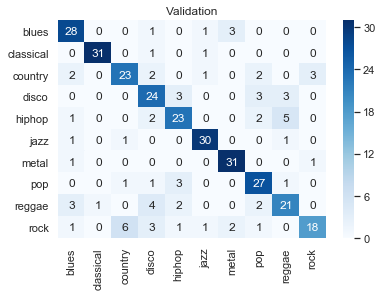

In [20]:
cm = confusion_matrix(y_max, y_pred_max)
sns.set()
plt.figure()
plt.title('Validation')
sns.heatmap(cm, annot=True, yticklabels=genres, xticklabels=genres, cmap='Blues')

### Save model

In [21]:
import h5py
model.save('model.h5')